Comparing the performance of fake review classification for a handufull of different classifiers while using the bag of word or TG-IDF text representation methods. 

In [1]:
#Imports

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import warnings
import time
from sklearn.metrics import accuracy_score
from collections import Counter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
#Seed used for all random operations in order to be able to replicate the experiment
seed = 3765

MODEL_NAMES = ["RandomForestClassifier", "AdaBoostClassifier", "KNearesNeighborsClassifier", "SVMClassifier", "MLPClassifier"]

In [3]:
bagOfWordsVectorizer = CountVectorizer()
tfidfVectorizer = TfidfVectorizer()

Create testing data

In [4]:
dataFrame = pd.read_csv('preprocessed_fake_reviews_dataset.csv')
dataFrame = dataFrame.dropna()
dataFrame['wordCount'] = dataFrame['reviewText'].apply(lambda x: len(x.split())).astype(str)
dataFrame = dataFrame.dropna()
dataFrame['punctuationCount'] = dataFrame['originText'].str.count(f'[{string.punctuation}]').astype(str)
dataFrame = dataFrame.dropna()
dataFrame = dataFrame.drop('Unnamed: 0', axis=1)

X = dataFrame['reviewText']
Y = dataFrame['label']

In [5]:
dataFrame.head()

,category,rating,label,reviewText,type,originText,wordCount,punctuationCount
0,Home_and_Kitchen,5.0,CG,love well made sturdy comfortable love pretty,1,"Love this! Well made, sturdy, and very comfor...",7,5
1,Home_and_Kitchen,5.0,CG,love great upgrade original 've mine couple year,1,"love it, a great upgrade from the original. I...",8,3
2,Home_and_Kitchen,5.0,CG,pillow saved back love look feel pillow,1,This pillow saved my back. I love the look and...,7,2
3,Home_and_Kitchen,1.0,CG,missing information use great product price,1,"Missing information on how to use it, but it i...",6,2
4,Home_and_Kitchen,5.0,CG,nice set good quality set two month,1,Very nice set. Good quality. We have had the s...,7,2


In [6]:
trainData, testData, trainLabels, testLabels = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=seed, shuffle=True)

In [7]:
trainData.shape, testData.shape, trainLabels.shape, testLabels.shape

((32344,), (8087,), (32344,), (8087,))

In [8]:
validationData, trainData, validationLabels, trainLabels = train_test_split(trainData, trainLabels, train_size=0.1, test_size=0.9, shuffle=True)

In [9]:
validationData.shape, trainData.shape, validationLabels.shape, trainLabels.shape

((3234,), (29110,), (3234,), (29110,))

In [10]:
classifiersBagOfWords = {}
classifiersBagOfWords.update({"RandomForestClassifier": RandomForestClassifier()})
classifiersBagOfWords.update({"AdaBoostClassifier": AdaBoostClassifier()})
classifiersBagOfWords.update({"KNeighborsClassifier": KNeighborsClassifier()})
classifiersBagOfWords.update({"SVMClassifier": SVC()})
classifiersBagOfWords.update({"MLPClassifier": MLPClassifier()})

classifiersTFIDF = {}
classifiersTFIDF.update({"RandomForestClassifier": RandomForestClassifier()})
classifiersTFIDF.update({"AdaBoostClassifier": AdaBoostClassifier()})
classifiersTFIDF.update({"KNeighborsClassifier": KNeighborsClassifier()})
classifiersTFIDF.update({"SVMClassifier": SVC()})
classifiersTFIDF.update({"MLPClassifier": MLPClassifier()})

In [11]:
#Hyperparameters to optimize for each model
hyperParamLst = [
    {   #RandomForest
        'clf__n_estimators': [8,7,6,5,4,3,2,1],
        'clf__max_depth': [2,4,6,8,10,12,14,16]
    },


    {   #AdaBoost
        'clf__n_estimators': [10,20,30,40,50,60,70,75,80],
        'clf__learning_rate': [0.1,1,3,6,12,15,18,21,25]
    },

    {   #KNN
        'clf__n_neighbors': [1,3,5,7,10,12,13,14],
        'clf__p': [1,2]
    },

    {   #SVM
        'clf__kernel': ["linear", "poly", "rbf"],
        'clf__C': [0.1,2,3,5,7,10,12,14,16]
    },

    {   #MLP
        'clf__hidden_layer_sizes': [(4,2),(6,3),(6,4),(8,4),(10,5),(15,5),(15,10),(20,10),(30,15)],
        'clf__learning_rate': ["constant", "invscaling", "adaptive"]
    }
]

Optimize the hyperparameters for every model by utilizing 3-fold on the validation set

In [52]:
#Supress the warnings coming from sklearn
warnings.simplefilter("ignore")

optimalParamLstBagOfWords = []
optimalParamLstTFIDF = []
for keyClassifier, i in zip(classifiersBagOfWords, range(0, len(hyperParamLst))):
    pipelineBOW = Pipeline([("bagOfWords", bagOfWordsVectorizer), ("clf", classifiersBagOfWords[keyClassifier])])
    pipelineTFIDF = Pipeline([("tfidf", tfidfVectorizer), ("clf", classifiersTFIDF[keyClassifier])])

    gridSearchBOW = GridSearchCV(pipelineBOW, hyperParamLst[i], cv=3, scoring="accuracy")
    gridSearchBOW.fit(validationData, validationLabels)
    
    gridSearchTFIDF = GridSearchCV(pipelineTFIDF, hyperParamLst[i], cv=3, scoring="accuracy")
    gridSearchTFIDF.fit(validationData, validationLabels)

    print("Current Classifier:", keyClassifier)
    print("The optimal hyperparameters with 'bag of word' as vector representation: " + str(gridSearchBOW.best_params_) + ". This setup got the following accuracy: " + str(gridSearchBOW.best_score_ * 100) + "%")
    print("The optimal hyperparameters with 'TF-IDF' as vector representation: " + str(gridSearchTFIDF.best_params_) + ". This setup got the following accuracy: " + str(gridSearchTFIDF.best_score_ * 100) + "%")
    print("\n")

    optimalParamLstBagOfWords.append(gridSearchBOW.best_params_)
    optimalParamLstTFIDF.append(gridSearchTFIDF.best_params_)
    

Current Classifier: RandomForestClassifier
The optimal hyperparameters with 'bag of word' as vector representation: {'clf__max_depth': 16, 'clf__n_estimators': 8}. This setup got the following accuracy: 68.18181818181817%
The optimal hyperparameters with 'TF-IDF' as vector representation: {'clf__max_depth': 14, 'clf__n_estimators': 7}. This setup got the following accuracy: 70.65553494124921%


Current Classifier: AdaBoostClassifier
The optimal hyperparameters with 'bag of word' as vector representation: {'clf__learning_rate': 1, 'clf__n_estimators': 75}. This setup got the following accuracy: 72.94372294372295%
The optimal hyperparameters with 'TF-IDF' as vector representation: {'clf__learning_rate': 1, 'clf__n_estimators': 70}. This setup got the following accuracy: 75.72665429808288%


Current Classifier: KNeighborsClassifier
The optimal hyperparameters with 'bag of word' as vector representation: {'clf__n_neighbors': 7, 'clf__p': 1}. This setup got the following accuracy: 61.564625

Train and test the different classifiers with the training and test data

In [54]:
dfModelsResult = pd.DataFrame(columns=["Classifier", "Vector Representation", "Training Time (minutes)", "Accuracy (%)", "f1 score"])

resultLstBOW = []
resultLstTFIDF = []
for keyClassifier, i in zip(classifiersBagOfWords, range(0, len(optimalParamLstBagOfWords))):
    pipelineBOW = Pipeline([("bagOfWords", bagOfWordsVectorizer), ("clf", classifiersBagOfWords[keyClassifier])])
    pipelineBOW.set_params(**optimalParamLstBagOfWords[i])
    startTrainingTime = time.time()
    pipelineBOW.fit(trainData,trainLabels)
    stopTrainingTime = time.time()
    predictedLabels = pipelineBOW.predict(testData)

    row = {'Classifier': keyClassifier,
        'Vector Representation': "Bag of Words",
        "Training Time (minutes)": format(round((stopTrainingTime-startTrainingTime)/60,2)),
        "Accuracy (%)": np.mean(predictedLabels==testLabels)*100,
        "f1 score": f1_score(testLabels, predictedLabels, average="macro")
    }

    dfModelsResult = dfModelsResult.append(row, ignore_index=True)
    resultLstBOW.append(predictedLabels)

    pipelineTFIDF = Pipeline([("tfidf", tfidfVectorizer), ("clf", classifiersTFIDF[keyClassifier])])
    pipelineTFIDF.set_params(**optimalParamLstTFIDF[i])
    startTrainingTime = time.time()
    pipelineTFIDF.fit(trainData, trainLabels)
    stopTrainingTime = time.time()
    predictedLabels = pipelineTFIDF.predict(testData)

    row = {'Classifier': keyClassifier,
        'Vector Representation': "TF-IDF",
        "Training Time (minutes)": format(round((stopTrainingTime-startTrainingTime)/60,2)),
        "Accuracy (%)": np.mean(predictedLabels==testLabels)*100,
        "f1 score": f1_score(testLabels, predictedLabels, average="macro")
    }

    dfModelsResult = dfModelsResult.append(row, ignore_index=True)
    resultLstTFIDF.append(predictedLabels)


<bound method Pipeline.get_params of Pipeline(steps=[('bagOfWords', CountVectorizer()),
                ('clf', RandomForestClassifier(max_depth=16, n_estimators=8))])>
<bound method Pipeline.get_params of Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=14, n_estimators=7))])>


<bound method Pipeline.get_params of Pipeline(steps=[('bagOfWords', CountVectorizer()),
                ('clf', AdaBoostClassifier(learning_rate=1, n_estimators=75))])>
<bound method Pipeline.get_params of Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', AdaBoostClassifier(learning_rate=1, n_estimators=70))])>


<bound method Pipeline.get_params of Pipeline(steps=[('bagOfWords', CountVectorizer()),
                ('clf', KNeighborsClassifier(n_neighbors=7, p=1))])>
<bound method Pipeline.get_params of Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', KNeighborsClassifier(n_neighbors=3))])>


<bound method Pipeline.g

In [55]:
dfModelsResult

,Classifier,Vector Representation,Training Time (minutes),Accuracy (%),f1 score
0,RandomForestClassifier,Bag of Words,0.02,71.472734,0.710262
1,RandomForestClassifier,TF-IDF,0.02,70.965747,0.709182
2,AdaBoostClassifier,Bag of Words,0.09,76.245827,0.762012
3,AdaBoostClassifier,TF-IDF,0.15,78.323235,0.782663
4,KNeighborsClassifier,Bag of Words,0.01,62.285149,0.608794
5,KNeighborsClassifier,TF-IDF,0.01,62.705577,0.586132
6,SVMClassifier,Bag of Words,2.37,86.323729,0.863237
7,SVMClassifier,TF-IDF,8.14,89.229628,0.892260
8,MLPClassifier,Bag of Words,3.1,83.492024,0.834752
9,MLPClassifier,TF-IDF,5.96,82.576975,0.825603


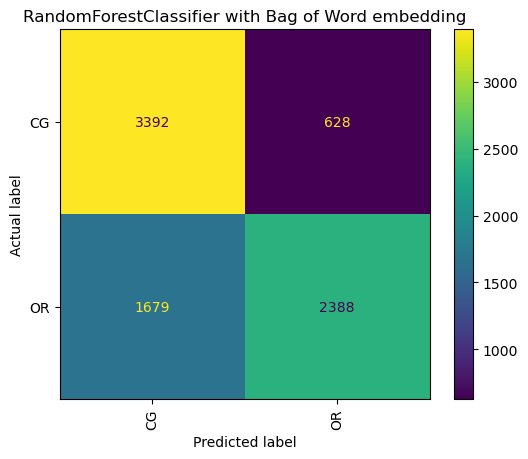

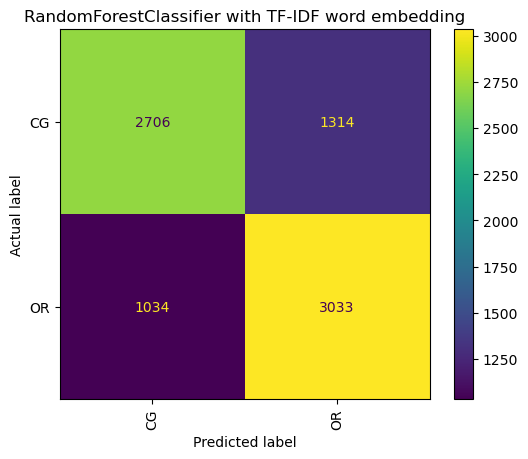

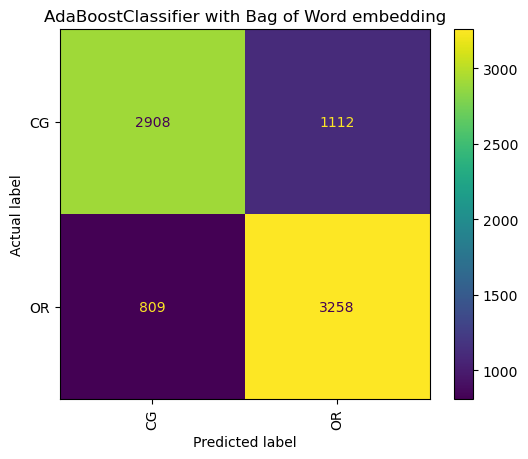

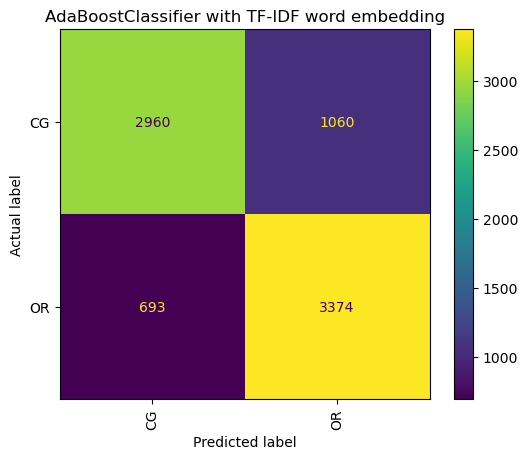

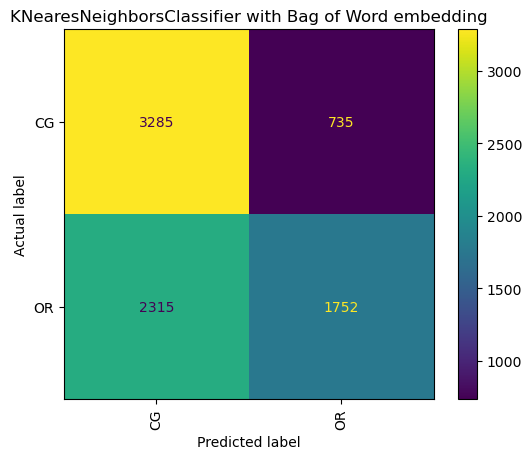

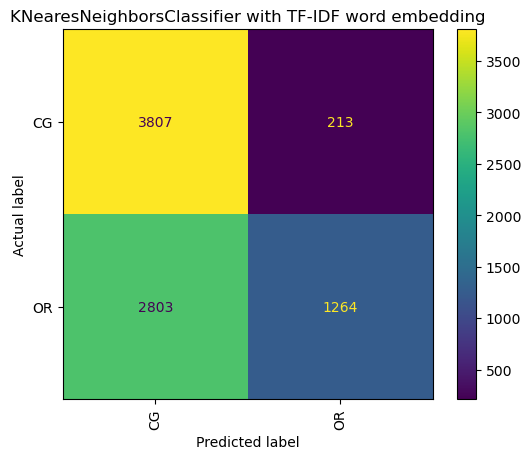

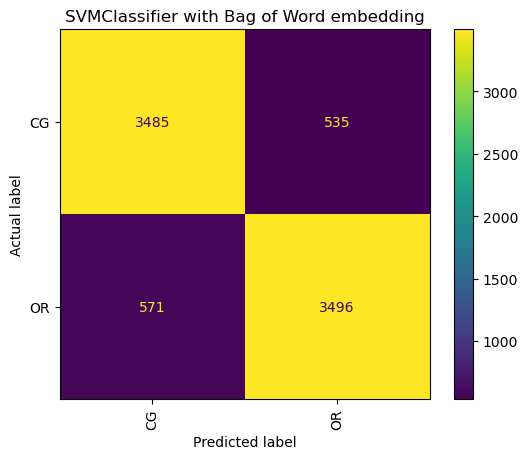

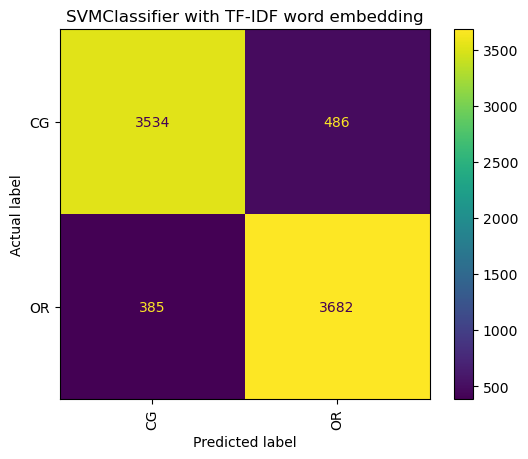

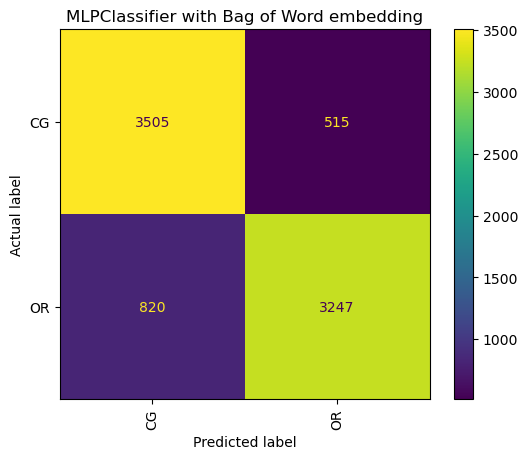

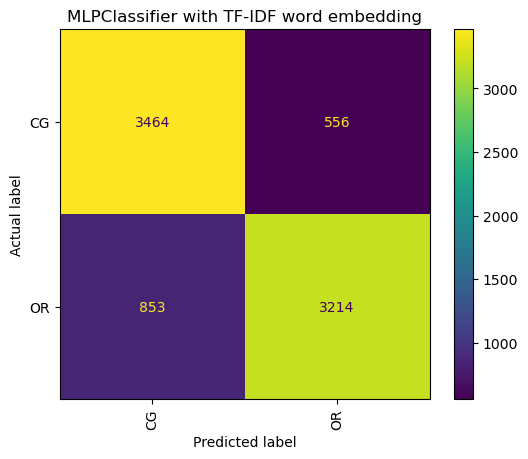

In [72]:
#Print the confusion matrices
for i in range(0, len(resultLstTFIDF)):
    ConfusionMatrixDisplay.from_predictions(testLabels, resultLstBOW[i], xticks_rotation="vertical")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(str(MODEL_NAMES[i]) +" with Bag of Word embedding")
    plt.show()

    ConfusionMatrixDisplay.from_predictions(testLabels, resultLstTFIDF[i], xticks_rotation="vertical")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(str(MODEL_NAMES[i]) +" with TF-IDF word embedding")
    plt.show()


In [12]:
def trainAndPredictForFeatures(features, vectorizer):
    
    warnings.simplefilter("ignore")
    
    predictions = []
    for feature in features:
        # Split the data into training and test sets
        trainData, testData, trainLabels, testLabels = train_test_split(dataFrame[feature], dataFrame['label'], test_size=0.20, random_state=seed)
        validationData, trainData, validationLabels, trainLabels = train_test_split(trainData, trainLabels, train_size=0.1, test_size=0.9, shuffle=True)

        classifiers = {}
        classifiers.update({"RandomForestClassifier": RandomForestClassifier()})
        classifiers.update({"AdaBoostClassifier": AdaBoostClassifier()})
        classifiers.update({"KNeighborsClassifier": KNeighborsClassifier()})
        classifiers.update({"SVMClassifier": SVC()})
        classifiers.update({"MLPClassifier": MLPClassifier()})

        print("Now processing feature: ", feature)
        print("Hyper parameter calculation phase")
        dataFrameModels = pd.DataFrame(columns=['model', 'run_time', "param_1", "param_2", 'acc_score'])
        bestParamLst = []
        for key, i in zip(classifiers, range(0, len(hyperParamLst))):
            pipeline = Pipeline([("vectorizer", vectorizer), ("clf", classifiers[key])])
            start_time = time.time()
            grid_search = GridSearchCV(pipeline, hyperParamLst[i], cv=3, scoring="accuracy")
            grid_search.fit(validationData, validationLabels)
            
            keys = list(grid_search.best_params_.keys())
            row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'param_1': grid_search.best_params_[keys[0]],
           'param_2':grid_search.best_params_[keys[1]],
           'acc_score': grid_search.best_score_
            }
            
            bestParamLst.append(grid_search.best_params_)

            dataFrameModels = dataFrameModels.append(row, ignore_index=True)
            
            
        display(dataFrameModels)

        print("Classification phase")
        # Use optimal hyperparameters to get result of each classifier with them
        dataFrameModels = pd.DataFrame(columns=['model', 'run_time', 'acc'])
        resultLst = []
        for key, i in zip(classifiers, range(0,len(bestParamLst))):
            pipeline = Pipeline([("vectorizer", vectorizer), ("clf", classifiers[key])])
            start_time = time.time()
            pipeline.set_params(**bestParamLst[i])
            pipeline.fit(trainData, trainLabels)
            predictedLabels = pipeline.predict(testData)
            resultLst.append(predictedLabels)

            row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'acc': np.mean(predictedLabels == testLabels) * 100
            }

            dataFrameModels = dataFrameModels.append(row, ignore_index=True)
        display(dataFrameModels)

        # Use a voting approach to combine the predictions from the individual classifiers
        final_preds = []
        for i in range(len(resultLst[0])):
            # Count the number of times each label appears in the list of predictions
            counts = Counter([result[i] for result in resultLst])

            # Select the most common label as the final prediction
            final_preds.append(counts.most_common(1)[0][0])

        # Evaluate the performance of the combined classifiers
        final_accuracy = accuracy_score(testLabels, final_preds)
        print(f'Accuracy after vote of classifiers using feature {feature}: {final_accuracy * 100}')
        predictions.append(final_preds)

    # Use a voting approach to combine the predictions from the individual features
    final_preds = []
    for i in range(len(predictions[0])):
        # Count the number of times each label appears in the list of predictions
        counts = Counter([result[i] for result in predictions])

        # Select the most common label as the final prediction
        final_preds.append(counts.most_common(1)[0][0])

    # Evaluate the performance of the combined classifiers
    final_accuracy = accuracy_score(testLabels, final_preds)
    print(f'Final accuracy after vote of features: {final_accuracy * 100}')

In [13]:
trainAndPredictForFeatures(["punctuationCount", "wordCount", "reviewText"], bagOfWordsVectorizer)

Now processing feature:  punctuationCount
Hyper parameter calculation phase


,model,run_time,param_1,param_2,acc_score
0,RandomForestClassifier,0.09,14,6,0.521027
1,AdaBoostClassifier,1.4,1,60,0.523500
2,KNeighborsClassifier,0.12,7,1,0.529066
3,SVMClassifier,0.29,0.1,rbf,0.533086
4,MLPClassifier,3.74,"(8, 4)",invscaling,0.532158


Classification phase


,model,run_time,acc
0,RandomForestClassifier,0.01,52.627674
1,AdaBoostClassifier,0.06,53.592185
2,KNeighborsClassifier,0.08,53.072833
3,SVMClassifier,0.4,54.062075
4,MLPClassifier,0.09,53.765302


Accuracy after vote of classifiers using feature punctuationCount: 53.83949548658341
Now processing feature:  wordCount
Hyper parameter calculation phase


,model,run_time,param_1,param_2,acc_score
0,RandomForestClassifier,0.11,16,4,0.533704
1,AdaBoostClassifier,1.02,1,80,0.533704
2,KNeighborsClassifier,0.1,10,1,0.541744
3,SVMClassifier,0.23,0.1,rbf,0.559988
4,MLPClassifier,2.5,"(6, 4)",adaptive,0.546382


Classification phase


,model,run_time,acc
0,RandomForestClassifier,0.0,51.502411
1,AdaBoostClassifier,0.06,54.494868
2,KNeighborsClassifier,0.11,52.454557
3,SVMClassifier,0.52,57.227649
4,MLPClassifier,0.1,56.782490


Accuracy after vote of classifiers using feature wordCount: 55.59540002473105
Now processing feature:  reviewText
Hyper parameter calculation phase


,model,run_time,param_1,param_2,acc_score
0,RandomForestClassifier,0.74,16,8,0.688621
1,AdaBoostClassifier,2.17,1,80,0.742424
2,KNeighborsClassifier,0.36,5,2,0.617192
3,SVMClassifier,2.44,0.1,linear,0.800247
4,MLPClassifier,9.99,"(6, 4)",invscaling,0.798392


Classification phase


,model,run_time,acc
0,RandomForestClassifier,0.03,69.580809
1,AdaBoostClassifier,0.18,76.381847
2,KNeighborsClassifier,0.2,63.027080
3,SVMClassifier,4.17,86.397923
4,MLPClassifier,9.16,82.045258


Accuracy after vote of classifiers using feature reviewText: 84.82750092741436
Final accuracy after vote of features: 70.92865092123161


In [14]:
trainAndPredictForFeatures(["punctuationCount", "wordCount", "reviewText"], tfidfVectorizer)

Now processing feature:  punctuationCount
Hyper parameter calculation phase


,model,run_time,param_1,param_2,acc_score
0,RandomForestClassifier,0.19,16,7,0.535869
1,AdaBoostClassifier,1.83,1,70,0.528757
2,KNeighborsClassifier,0.12,5,1,0.521336
3,SVMClassifier,0.29,0.1,rbf,0.542981
4,MLPClassifier,3.16,"(10, 5)",invscaling,0.532468


Classification phase


,model,run_time,acc
0,RandomForestClassifier,0.0,52.083591
1,AdaBoostClassifier,0.05,53.332509
2,KNeighborsClassifier,0.07,49.165327
3,SVMClassifier,0.46,54.062075
4,MLPClassifier,0.1,53.987882


Accuracy after vote of classifiers using feature punctuationCount: 53.74057128725115
Now processing feature:  wordCount
Hyper parameter calculation phase


,model,run_time,param_1,param_2,acc_score
0,RandomForestClassifier,0.18,16,8,0.518862
1,AdaBoostClassifier,1.21,1,80,0.510823
2,KNeighborsClassifier,0.15,3,1,0.512369
3,SVMClassifier,0.31,0.1,rbf,0.556895
4,MLPClassifier,3.32,"(15, 10)",invscaling,0.538343


Classification phase


,model,run_time,acc
0,RandomForestClassifier,0.01,51.712625
1,AdaBoostClassifier,0.06,54.841103
2,KNeighborsClassifier,0.07,54.457772
3,SVMClassifier,1.08,57.338939
4,MLPClassifier,0.12,56.733028


Accuracy after vote of classifiers using feature wordCount: 56.015827871893165
Now processing feature:  reviewText
Hyper parameter calculation phase


,model,run_time,param_1,param_2,acc_score
0,RandomForestClassifier,0.66,16,7,0.705009
1,AdaBoostClassifier,3.34,1,80,0.744898
2,KNeighborsClassifier,0.36,1,2,0.602350
3,SVMClassifier,3.57,2,rbf,0.821892
4,MLPClassifier,18.43,"(6, 4)",constant,0.796228


Classification phase


,model,run_time,acc
0,RandomForestClassifier,0.04,70.866823
1,AdaBoostClassifier,0.27,78.805490
2,KNeighborsClassifier,0.17,64.214171
3,SVMClassifier,10.31,89.044145
4,MLPClassifier,8.24,80.165698


Accuracy after vote of classifiers using feature reviewText: 85.79201187090392
Final accuracy after vote of features: 73.0060591072091
